<a href="https://colab.research.google.com/github/vivianchen98/Assignment-1-Comparison-of-Regression-Models-on-Predicting-Medical-Costs/blob/master/Copy_of_CS_4774_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment 1: Comparison of Regression Models on Predicting Medical Costs

### CS 4774 Machine Learning - Department of Computer Science - University of Virginia
![Medical Cost](https://creditkarma-cms.imgix.net/wp-content/uploads/2018/04/boomers-gen-x-high-cost-medical-care.jpg)
In this assignment, you will implement some learning models in the context of a **regression** problem in the [Medical Cost Personal Dataset on Kaggle](https://www.kaggle.com/mirichoi0218/insurance). Specifically, you will attempt to predict the medical cost billed by health insurance using other provided patient's data. For references, you may refer to [my slides](https://docs.google.com/presentation/d/10D1he89peAWaFgjtZlHpUzvOOAie_vIFT95htKCKgc0/edit#slide=id.p) or the Google Colab if you need additional sample codes to help with your assignment. To get started, you will need to upload/copy the dataset (.csv) into the same folder as this file. 

For deliverables, you must write code in Colab and submit the downloaded Jupyter Notebook file (.ipynb) to earn a total of 100 pts. You will gain points depending on how you perform in the following sections.


***
##  Task 1: SEE THE BIG PICTURE (5 pts)
Write a paragraph explaining the context of the problem in which you are trying to investigate. We will assume that the data file is put into the same workspace on Colab. Then, you can write some code to load the CSV file and take a quick look at the dataset, and output the following:

 * How big is your dataset? (in terms of MB)
 * How many entries does it have?
 * How many features does it have?
 * Does it contain any categorical data?
 * Is there any missing value?
 * What are some basic statistics you can learn right away about this dataset?

In [0]:
# Import some common packages
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# Your code goes here for this section, make sure you also include the output to answer the above questions.
DOWNLOAD_URL = "https://raw.githubusercontent.com/vivianchen98/Assignment-1-Comparison-of-Regression-Models-on-Predicting-Medical-Costs/master/insurance.csv"

#get the data
data = pd.read_csv(DOWNLOAD_URL)

In [2]:
# see the info of the data
data.info()
# data.head()

# The dataset is 73.3+ KB = 0.0733 MB
# There are 1338 entries in it
# There are 7 features
# There are 3 categorical data: sex, smoker, region

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
age         1338 non-null int64
sex         1338 non-null object
bmi         1338 non-null float64
children    1338 non-null int64
smoker      1338 non-null object
region      1338 non-null object
charges     1338 non-null float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [3]:
# Check to see if there's any missing value in the data with .isnull()
data_incomplete_rows = data[data.isnull().any(axis=1)].head()
data_incomplete_rows

# no missing data

,age,sex,bmi,children,smoker,region,charges


In [4]:
# Basic statistics for numerical data
data.describe() 

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [5]:
# basic statistics for categorical data

# sex
data.groupby('sex').mean()

# male's mean charge is higher than females by 11%

,age,bmi,children,charges
sex,,,,
female,39.503021,30.377749,1.074018,12569.578844
male,38.917160,30.943129,1.115385,13956.751178


In [6]:
# smoker
data.groupby('smoker').mean()

# smokers' mean charge is higher than non-smokers by 280%!!

,age,bmi,children,charges
smoker,,,,
no,39.385338,30.651795,1.090226,8434.268298
yes,38.514599,30.708449,1.113139,32050.231832


In [7]:
# region
data.groupby('region').mean()

# the four regions are roughly in the same range for charges, with desceding order: SE > NE > NW > SW

,age,bmi,children,charges
region,,,,
northeast,39.268519,29.173503,1.046296,13406.384516
northwest,39.196923,29.199785,1.147692,12417.575374
southeast,38.939560,33.355989,1.049451,14735.411438
southwest,39.455385,30.596615,1.141538,12346.937377


---
##  Task 2: DATA DISCOVERY, CLEANING, AND SCALING (25 pts)

**Data Discover:** Plot out all correlations among the features. You may notice some features are more correlated with your predicted value than other. This information will help you confirm that weights of your regression model later on.

**Data Cleaning:** If your dataset has some missing values, make sure you are able to fill those values with the Imputer class. If your dataset has categorical features, make sure you conver those features into numerical using OneHotEncoder class. 

**Feature Scaling** More importantly, your task is to write some codes to normalize the value of each features as follow:

* Subtract the mean value of each feature from the dataset
* Scale (divide) the feature values by their respective standard deviation

**Implementation Note:** You will need to integrate the above operations into a Pipeline to process and transform the training data, then use the same pipeline to transform any validation and testing data.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f78b5c389b0>,
      dtype=object)

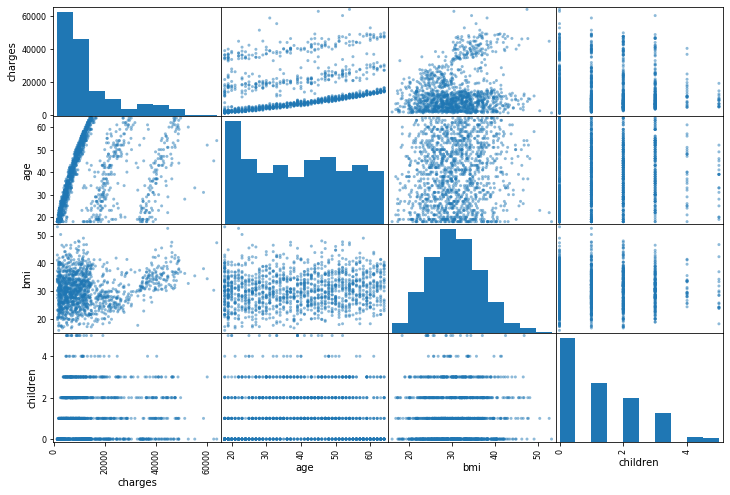

In [8]:
# You might want to use the following package
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix # optional
# from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.compose import ColumnTransformer

# Data discorver: visualize the correlation in data
attributes = ["charges", "age", "bmi", "children"]
scatter_matrix(data[attributes], figsize=(12, 8))

In [0]:
# check for missing data --> no missing

In [0]:
# split train and test sets
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

In [11]:
# Create the features and labels for training
X_train = train_set.drop("charges", axis=1)# drop labels for training set
y_train = train_set["charges"].copy()

# for testing
X_test = test_set.drop("charges", axis=1)
y_test = test_set["charges"].copy()
y_test

764      9095.06825
887      5272.17580
890     29330.98315
1293     9301.89355
259     33750.29180
           ...     
109     47055.53210
575     12222.89830
535      6067.12675
543     63770.42801
846      9872.70100
Name: charges, Length: 268, dtype: float64

In [0]:
# pipeline for numerical values
num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])


In [0]:
# full pipeline of numerical + categorical data

num_attribs = ["age", "bmi", "children"]
cat_attribs = ["sex", "smoker", "region"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

In [0]:
# pipelining the two sets
X_train = full_pipeline.fit_transform(X_train)
X_test = full_pipeline.fit_transform(X_test)

- - -
## Task 3. IMPLEMENT GRADIENT DESCENT (30 pts)
The gradient descent formulation remain the same as one in the lecture. Keep in mind that you will need to add a column $\textbf{x}_0$ with all 1s as part of the training data. You should write code to implement the **MyLinearRegression** class and its predefined methods. 

**Gradient Descent:** Notes that you may NOT call the library linear regression which defeats the purpose of this assignment. Make sure your code is well-vectorized.

In [0]:
# NOTE: You may not use the library Linear Regression, but implement your own!
# REMEMBER to place self.attribute = 0 with value from your implementation

class MyLinearRegression:
  """
  Define what a linear regressor can do
  """

  def __init__ (self):
    """
    Initialize the regressor
    """
    self.theta = 0; # parameter vector;
    self.alpha = 0; # learning rate
    self.cost  = 0; # cost function
    self.cost_arr = [] # cost func array (to be plotted)

  def gradientDescent(self, X_train, y_train, theta, alpha, iters):
    """
    Implementatation of the gradient descent
    INPUT:
    alpha: the learning rate
    iters: number of iterations

    OUTPUT: 
    theta: updated value for theta
    cost: value of the cost function
    """
    # implementation code here
    m = X_train.shape[0]

    for iter in range(iters):
      gradients = 2/m * X_train.T.dot(X_train.dot(theta)-y_train)
      theta -= gradients * alpha
      self.cost = 1/m* (X_train.dot(theta)-y_train).T.dot(X_train.dot(theta)-y_train)
      self.cost_arr.append(self.cost)
    return theta, self.cost

  def fitUsingGradientDescent(self, X_train, y_train, alpha):
    """
    Train the regressor using gradient descent
    """
    # implementation code here
    theta = np.zeros(12)
    #alpha = passed in value     #learning rate
    iters = 100     #iterations

    X_train_b = np.c_[np.ones((len(X_train),1)), X_train] #add x0=1 to each instance
    y_train = np.array(y_train)
    self.theta, self.cost = self.gradientDescent(X_train_b, y_train, theta, alpha, iters)

  def fitUsingNormalEquation(self, X_train, y_train):
    """
    Training using the Normal (close form) equation
    """
    # implementation code here for Task 4.
    X_b = np.c_[np.ones((len(X_train),1)), X_train] #add x0=1 to each instance
    theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y_train)
    self.theta = theta_best

  def predict(self, X_test):
    """
    Predicting the label
    """
    # implementation code here 
    X_test_b = np.c_[np.ones((len(X_test),1)), X_test] #add x0=1 to each instance
    y_predict = X_test_b.dot(self.theta)
    return y_predict

  def __str__(self):
    """
    Print out the parameter out when call print()
    """
    # implement here to return("Parameter vector is %f" % self.theta)   }
    return("Parameter vector is %f" % self.theta)
    
# Your code goes here to call the instance of class MyLinearRegression
myGradientDescentModel1 = MyLinearRegression()
myGradientDescentModel1.fitUsingGradientDescent(X_train, y_train, 0.1)  

myGradientDescentModel2 = MyLinearRegression()
myGradientDescentModel2.fitUsingGradientDescent(X_train, y_train, 0.2) 

myGradientDescentModel3 = MyLinearRegression()
myGradientDescentModel3.fitUsingGradientDescent(X_train, y_train, 0.35)

* **Learning Rate:** You will try out different learning rates for the dataset and find a learning rate that converges quickly. If you pick a learning rate, your plot of Cost Function $J(\theta)$ against number of iteration will quickly decay to a small value. This also indicates that your implementation is correct. If your learning rate is too large, the cost function $J(\theta)$ can diverge and blow up. From the below plot, you must be able to report the best learning rate the you found to earn credit for this section.

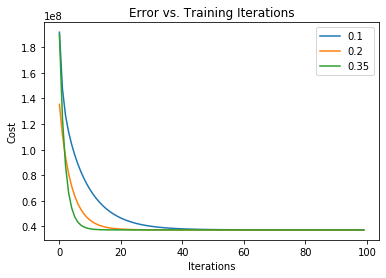

In [16]:
# Use the following code to plot out your learning rate
# iters and cost must be supplied to plot out the cost function
# You may plot multiple curves corresponding to different learning rates to justify the best one.

plt.plot(myGradientDescentModel1.cost_arr, label='0.1')
plt.plot(myGradientDescentModel2.cost_arr, label='0.2')
plt.plot(myGradientDescentModel3.cost_arr, label='0.35')
plt.xlabel('Iterations')  
plt.ylabel('Cost')  
plt.title('Error vs. Training Iterations') 
plt.legend()

- - -
## Task 4. IMPLEMENT THE NORMAL EQUATION (10 pts)

In my lecture, you learn that the closed form solution of linear regression using the normal equation formulation. Using the formula does not require any feature scaling, and should be straight forward to implement: 

$
    \mathbf{\theta} = ({\mathbf{X}^{T}\mathbf{X}})^{-1}\mathbf{X}^{T}\mathbf{y}.
$

Note that you still need to add a column of 1's to the $\mathbf{
X}$ matrix to have an intercept term.

In [0]:
# Implement the normalEquation method of the MyLinearRegression Class before execute the code below:
myNormalEquationModel = MyLinearRegression()
myNormalEquationModel.fitUsingNormalEquation(X_train, y_train)

- - -
## Task 5. COMPARE DIFFERENT IMPLEMENTATIONS (20 pts)

You should be able to evaluate and compare your gradient descent as well as normal equation implementation of linear regression. In theory, they should be the same, or at least similar. For good measures, you may also use the built-in library **Scholastic Gradient Descent (SGD)** as a third model for comparison. For each model, you must compute the RMSE on the **test set** as performance measure. The good news is that you can call library functions to compute these as shown below instead of writing your own code:

* Which one yields the best performance measure for your dataset?
* What is your assessment of the error? Good? Okay? Terrible?

In [18]:
from sklearn.metrics import mean_squared_error

# Use the built-in SGD Regressor model
from sklearn.linear_model import SGDRegressor
mySGDModel = SGDRegressor()
mySGDModel.fit(X_train,y_train)
y_predict = mySGDModel.predict(X_test)
mse = mean_squared_error(y_test, y_predict)
mySGDModel_rmse = np.sqrt(mse)
print(mySGDModel_rmse)


5799.591810991122


In [19]:
# myGradientDescentModel_rmse  
myGradientDescentModel2 = MyLinearRegression()
myGradientDescentModel2.fitUsingGradientDescent(X_train, y_train, 0.35)
y_predict = myGradientDescentModel2.predict(X_test)
mse = mean_squared_error(y_test, y_predict)
myGradientDescentModel_rmse = np.sqrt(mse)
print(myGradientDescentModel_rmse)

5795.3325406562435


In [20]:
# myNormalEquationModel_rmse 
myNormalEquationModel = MyLinearRegression()
myNormalEquationModel.fitUsingNormalEquation(X_train, y_train)
y_predict = myNormalEquationModel.predict(X_test)
mse = mean_squared_error(y_test, y_predict)
myNormalEquationModel_rmse = np.sqrt(mse)
print(myNormalEquationModel_rmse)

9462.247104641756


- - -
## Task 6. PRESENT YOUR SOLUTION (10 pts)

Now that you need to write a short memo of one paragraph to be read by a non-technical audience (ie. your manager/boss). Focus on answering the following: 

* How can you pitch your solution to this project? 
* What did you learn so far about the problem?
* Is there any insight moving forward to improve the solution.

In [0]:
# To solve the problem of predicting the medical cost billed by health insurance using patients' other data as features, 
# I successfully trained two models on the prepared data, one using the method of gradient descent, the other using the
# method of the normal equation. 

# It is worth notice that there are no missing data in the data sets, and all categorical data is encoded using OneHotEncoder, 
# while the numerical features are scaled using standard scaler. 

# After a careful choice of learning rate, the current results shows the gradient descent has the best performance while 
# the normal equation has the worst. 

# In the future, the model could potentially have better performance by applying some suitable regularizations on the model.


# Summary of the project

In this project, the goal is to predict the medical cost (**label** "charges") billed by health insurance using other provided patient's data (**features** including age, sex, bmi, whether a smoker, the number of children and the region the patient is from).

1.   **Data discover**: To solve this regression problem, I investigated the correlaetion between different features against charges, the results showed that:
  *   male's mean charge is higher than females by 11%
  *   smokers' mean charge is higher than non-smokers by 280%!!
  *   the four regions are roughly in the same range for charges, with desceding order: SE > NE > NW > SW
  *   charge increases with age
  *   no strong correlation between bmi and children with respect to charges

2. **split** the data into train_set and test_set

3. **Data cleaning**: 
  *   Split each data set into features and label -> X_train (train_set features), y_train (train_set label), X_test (test_set features), y_test (test_set label).
  *   Found no missing data
  *   define a pipeline where:
      *   categorical data is transformed with *OneHotEncoder*
      *   numerical data is scaled with *StandardScaler*
  *   transform the features data sets with the defined pipeline

4. **Select and Train models**: In this project, two method were used, which are **gradient descent** and the **normal equation**, respectively.

5. **Fine-tune the model** This is mostly for the gradient-descent method where we need to choose an appropriate learning rate, alpha.
    I plotted the value of cost function versus iterations for different learning rates and select the one with the fastest decreasing slope (0.35).

6. **Performance evaluation** 

    *  rmse of *myGradientDescent* = 5795.3325406562435
    *  rmse of *mySGDModel* = 5798.395220467633
    *  rmse of *myNormalEquationModel* = 9462.247104641756

    Clearly, gradient descent generates has the smallest error, slightly under that of SGD model, while normal equation's error is well beyond the SGD error.

    Also, gradient descent has a better computational complexity in training the model since it is an iterative process.
    

- - - 
### NEED HELP?

In case you get stuck in any step in the process, you may find some useful information from:

 * Consult my [slides](https://docs.google.com/presentation/d/10D1he89peAWaFgjtZlHpUzvOOAie_vIFT95htKCKgc0/edit?usp=sharing) and/or the textbook
 * Talk to the TA, they are available and there to help you during [office hour](http://bit.ly/cs4774oh)
 * Come talk to me or email me <nn4pj@virginia.edu> with subject starting "CS4774 Assignment 1:...".

Best of luck and have fun!